# Прогнозирование температуры звезды

В данном проекте выполняется задача от обсерватории «###»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики:
- Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе - спектрального анализа.
- Тип звезды.
- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

**Цель проекта:**

Разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-0">Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-0.1">Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-и-анализ-данных" data-toc-modified-id="Предобработка-и-анализ-данных-1">Предобработка и анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Построение-базовой-нейронной-сети" data-toc-modified-id="Построение-базовой-нейронной-сети-2">Построение базовой нейронной сети</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1">Вывод</a></span></li></ul></li><li><span><a href="#Улучшение-нейронной-сети" data-toc-modified-id="Улучшение-нейронной-сети-3">Улучшение нейронной сети</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1">Вывод</a></span></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4">Сравнение моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1">Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5">Общий вывод</a></span></li></ul></div>

## Загрузка данных

In [1]:
pip check

pyspark 3.0.2 has requirement py4j==0.10.9, but you have py4j 0.10.9.3.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep matplotlib
!pip list | grep scikit-learn
!pip list | grep seaborn
!pip list | grep shap
!pip list | grep phik

numpy                             1.26.4
pandas                            2.2.3
matplotlib                        3.9.4
matplotlib-inline                 0.1.2
scikit-learn                      1.6.1
seaborn                           0.13.2
shap                              0.45.0
phik                              0.12.4


In [3]:
!pip install \
    numpy==1.26.4 \
    pandas==2.2.3 \
    matplotlib==3.9.4 \
    matplotlib-inline==0.1.2 \
    pyarrow==14.0.2 \
    seaborn==0.13.2 \
    scikit-learn==1.6.1 \
    shap==0.45.0 \
    phik \
    tabulate

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from tabulate import tabulate

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import (root_mean_squared_error, 
                             make_scorer)

from sklearn.compose import ColumnTransformer
from itertools import product
from phik.report import plot_correlation_matrix
from torch.utils.data import DataLoader

RANDOM_STATE=45

In [5]:
# Функция для получения общей информации о датасете
def get_info(data):
    display(data.head())
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количество пропусков:\n', data.isna().sum())

In [6]:
data = pd.read_csv('###.csv')

In [7]:
get_info(data)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00



Количество явных дубликатов: 0
Количество пропусков:
 Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64


### Вывод

1. **Объем данных**  
   В датасете содержится 240 наблюдений (строк). Каждая строка соответствует одной звезде.

2. **Температура (K)**  
   - Средняя температура звезд составляет около **10 497 K**, но разброс значений очень велик (стандартное отклонение — **9 552 K**).  
   - Минимальная температура: **1 939 K**, максимальная — **40 000 K**.  
   - Медиана (**5 776 K**) значительно ниже среднего, что указывает на правостороннюю асимметрию (большое количество относительно холодных звезд и несколько экстремально горячих).

3. **Светимость (L/Lo)**  
   - Средняя светимость (**107 188 L/Lo**) сильно завышена из-за выбросов (стандартное отклонение — **179 432**).  
   - Медиана (**0.0705 L/Lo**) близка к нулю, что говорит о преобладании звезд с низкой светимостью .  
   - Максимальная светимость (**849 420 L/Lo**) соответствует сверхгигантам.  

4. **Радиус (R/Ro)**  
   - Средний радиус (**237 R/Ro**) также искажен выбросами (стандартное отклонение — **517**).  
   - Медиана (**0.7625 R/Ro**) близка к солнечному радиусу, но есть звезды с радиусом до **1 948.5 R/Ro** (гипергиганты).  
   - Минимальный радиус (**0.0084 R/Ro**) может соответствовать белым карликам или нейтронным звездам.  

5. **Абсолютная звездная величина (Mv)**  
   - Среднее значение (**4.38**) малопоказательно из-за большого разброса (**σ = 10.53**).  
   - Медиана (**8.31**) указывает на преобладание тусклых звезд.  
   - Минимальное значение (**-11.92**) характерно для очень ярких звезд (например, сверхновых).  

## Предобработка и анализ данных

Удалим столбец `Unnamed: 0`, не показателен для прогноза.

In [8]:
data = data.drop('Unnamed: 0', axis=1)

Переведем названия столбцов в змеиный регистр.

In [9]:
data.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

Посмотрим уникальные значения категориальных столбцов.

In [10]:
cat_col = ['star_type', 'star_color']

In [11]:
for column in cat_col:
    print(f"\nУникальные значения в столбце '{column}':")
    print(data[column].unique())


Уникальные значения в столбце 'star_type':
[0 1 2 3 4 5]

Уникальные значения в столбце 'star_color':
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


Типы звезд обозначены соответствующими номерами, переименуем их в названия из описания к проекту.

In [12]:
star_mapping = {
    0: 'brown dwarf',
    1: 'red dwarf',
    2: 'white dwarf',
    3: 'main sequence',
    4: 'supergiant',
    5: 'hypergiant'
}

In [13]:
data['star_type'] = data['star_type'].replace(star_mapping)

В `star_color` избавимся от неявных дубликатов, обусловленных написанием.

In [14]:
data['star_color'] = data['star_color'].apply(lambda x: ' '.join(sorted(x.lower().replace('-', ' ').split())))

In [15]:
for column in cat_col:
    print(f"\nУникальные значения в столбце '{column}':")
    print(data[column].unique())


Уникальные значения в столбце 'star_type':
['brown dwarf' 'red dwarf' 'white dwarf' 'main sequence' 'supergiant'
 'hypergiant']

Уникальные значения в столбце 'star_color':
['red' 'blue white' 'white' 'white yellowish' 'orange pale yellow' 'blue'
 'whitish' 'white yellow' 'orange' 'yellowish' 'orange red']


Теперь посмотрим распределение данных.

In [16]:
def hist_box(df, column):
    plt.figure(figsize=(15, 5))
    
    # Количество интервалов (bins) будет рассчитано как квадратный корень из числа наблюдений
    num_bins = int(np.sqrt(len(df[column])))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Количество наблюдений')
    plt.title(f'Гистограмма для "{column}"')
    sns.histplot(df[column], bins=num_bins)  # Используем количество интервалов num_bins

    # Диаграмма размаха
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.title(f'Диаграмма размаха для "{column}"')
    sns.boxplot(x=df[column])
    
    plt.tight_layout()
    plt.show()

In [17]:
#cat_col
num_col = ['temperature', 'luminosity', 'radius', 'absolute_magnitude'] 

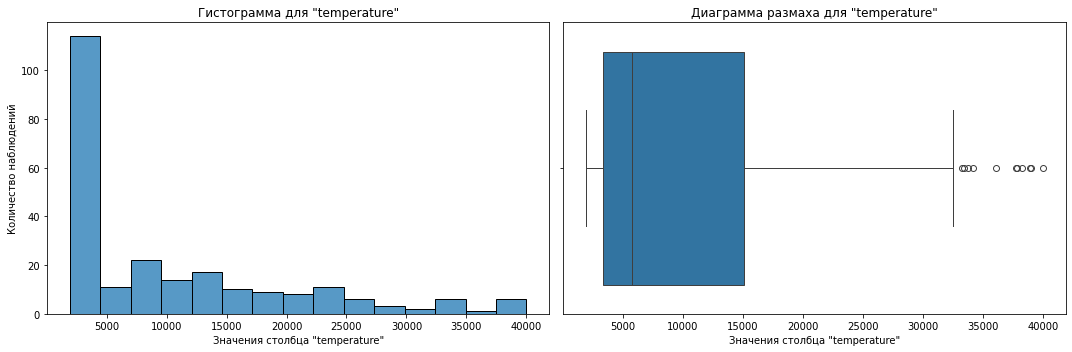

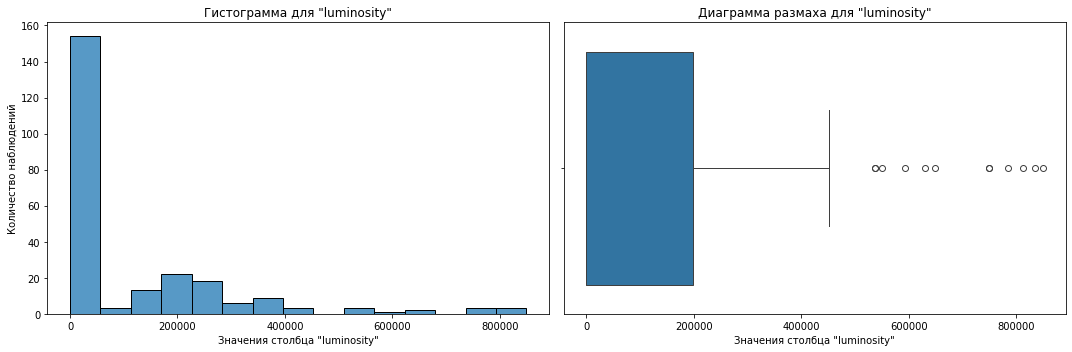

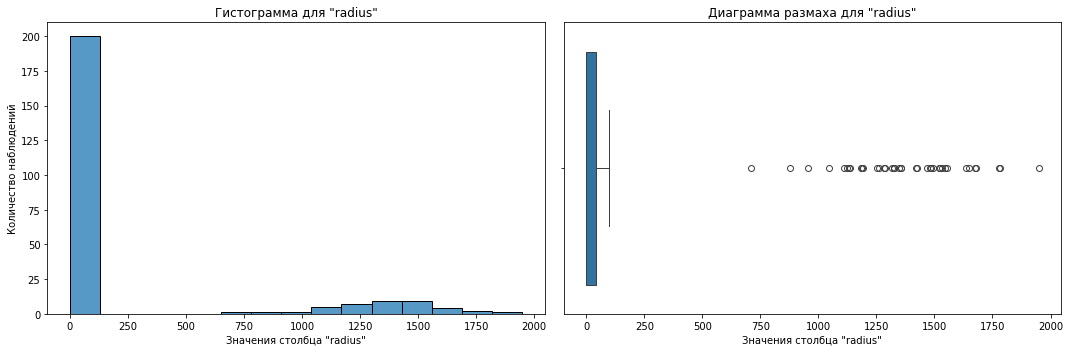

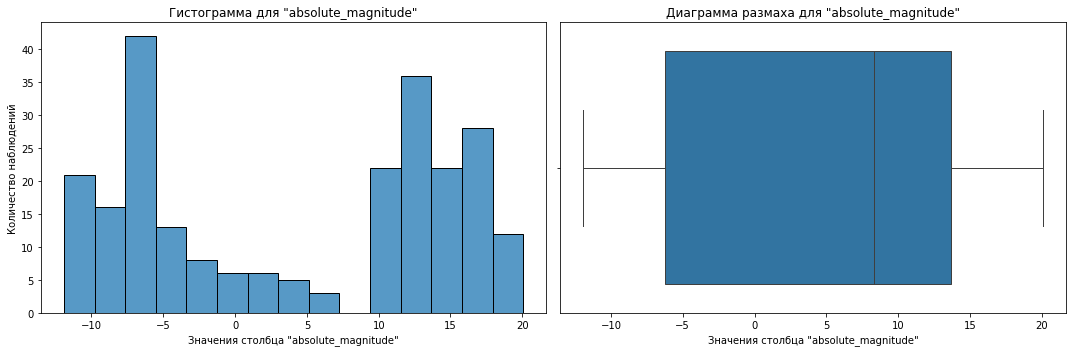

In [18]:
for name in num_col:
    hist_box(data, name)

**Температура**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.
  
**Относительная светимость**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.
  
**Относительный радиус**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.

**Абсолютная звёздная величина**
  - Признак без выбросов, имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика. Меньше всего значений в диапазоне 0-5.

Признаки `radius` и `luminosity` сильно скошены. Применим к ним логарифмирование для выравнивания.

In [19]:
data['luminosity'] = np.log(data['luminosity'])
data['radius'] = np.log(data['radius'])

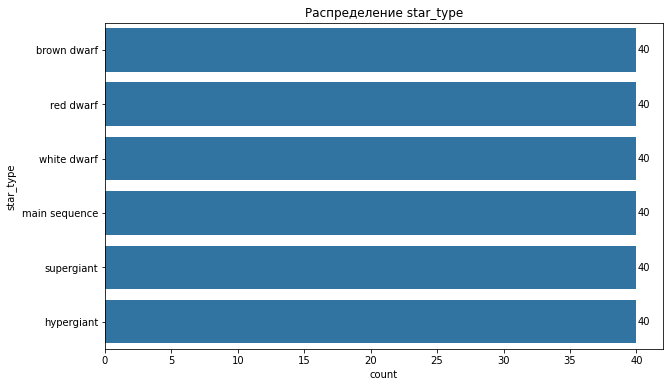

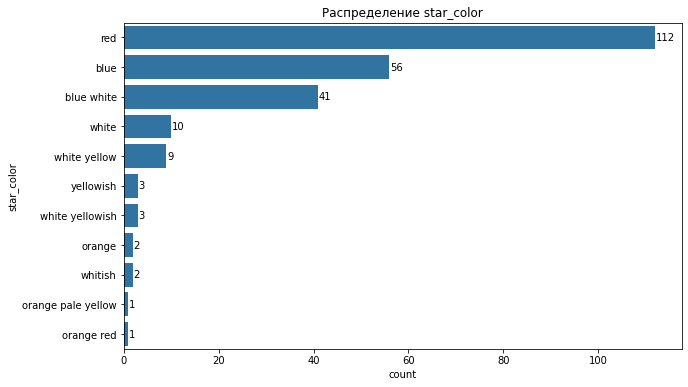

In [20]:
for col in cat_col:
    # Получаем топ-20 самых частых значений
    if data[col].nunique() > 20:
        top_20 = data[col].value_counts().nlargest(20).index
        filtered_data = data[data[col].isin(top_20)]
    else:
        filtered_data = data
    
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(
        y=filtered_data[col],
        order=filtered_data[col].value_counts().index  # Сортируем по частоте
    )
    plt.title(f'Распределение {col}' + (' (Топ-20)' if data[col].nunique() > 20 else ''))
    
    # Добавляем подписи к каждому столбцу вручную
    for p in ax.patches:
        width = p.get_width()  # Получаем ширину столбца (количество наблюдений)
        ax.text(
            width + 0.1,  # x-координата текста (немного правее столбца)
            p.get_y() + p.get_height() / 2,  # y-координата текста (по центру столбца)
            f'{int(width)}',  # Текст (количество наблюдений)
            va='center'  # Выравнивание по вертикали
        )
    
    plt.show()

- Имеем равное распределение наблюдений по типам звезд - 40.
- В данных преобладают звезды цветов `red`, `blue`, `blue white`. Также имеем цвета с 1-3 наблюдениями. Попробуем провести объединение единичных цветов.

Посмотрим распределение типов и цветов звезд по их температуре.

In [21]:
quantitative_scatter = ['luminosity', 'radius', 'absolute_magnitude']

def plot_scatter_plots(data, quantitative_features, hue):
    plt.figure(figsize=(20, 30))
    for i, feature in enumerate(quantitative_features, 1):
        plt.subplot(3, 1, i)
        sns.scatterplot(data=data, x=feature, y='temperature', hue=hue, 
                        alpha=0.5, s=200)
        plt.title(f'Связь temperature с {feature}')

    plt.tight_layout()
    plt.show()

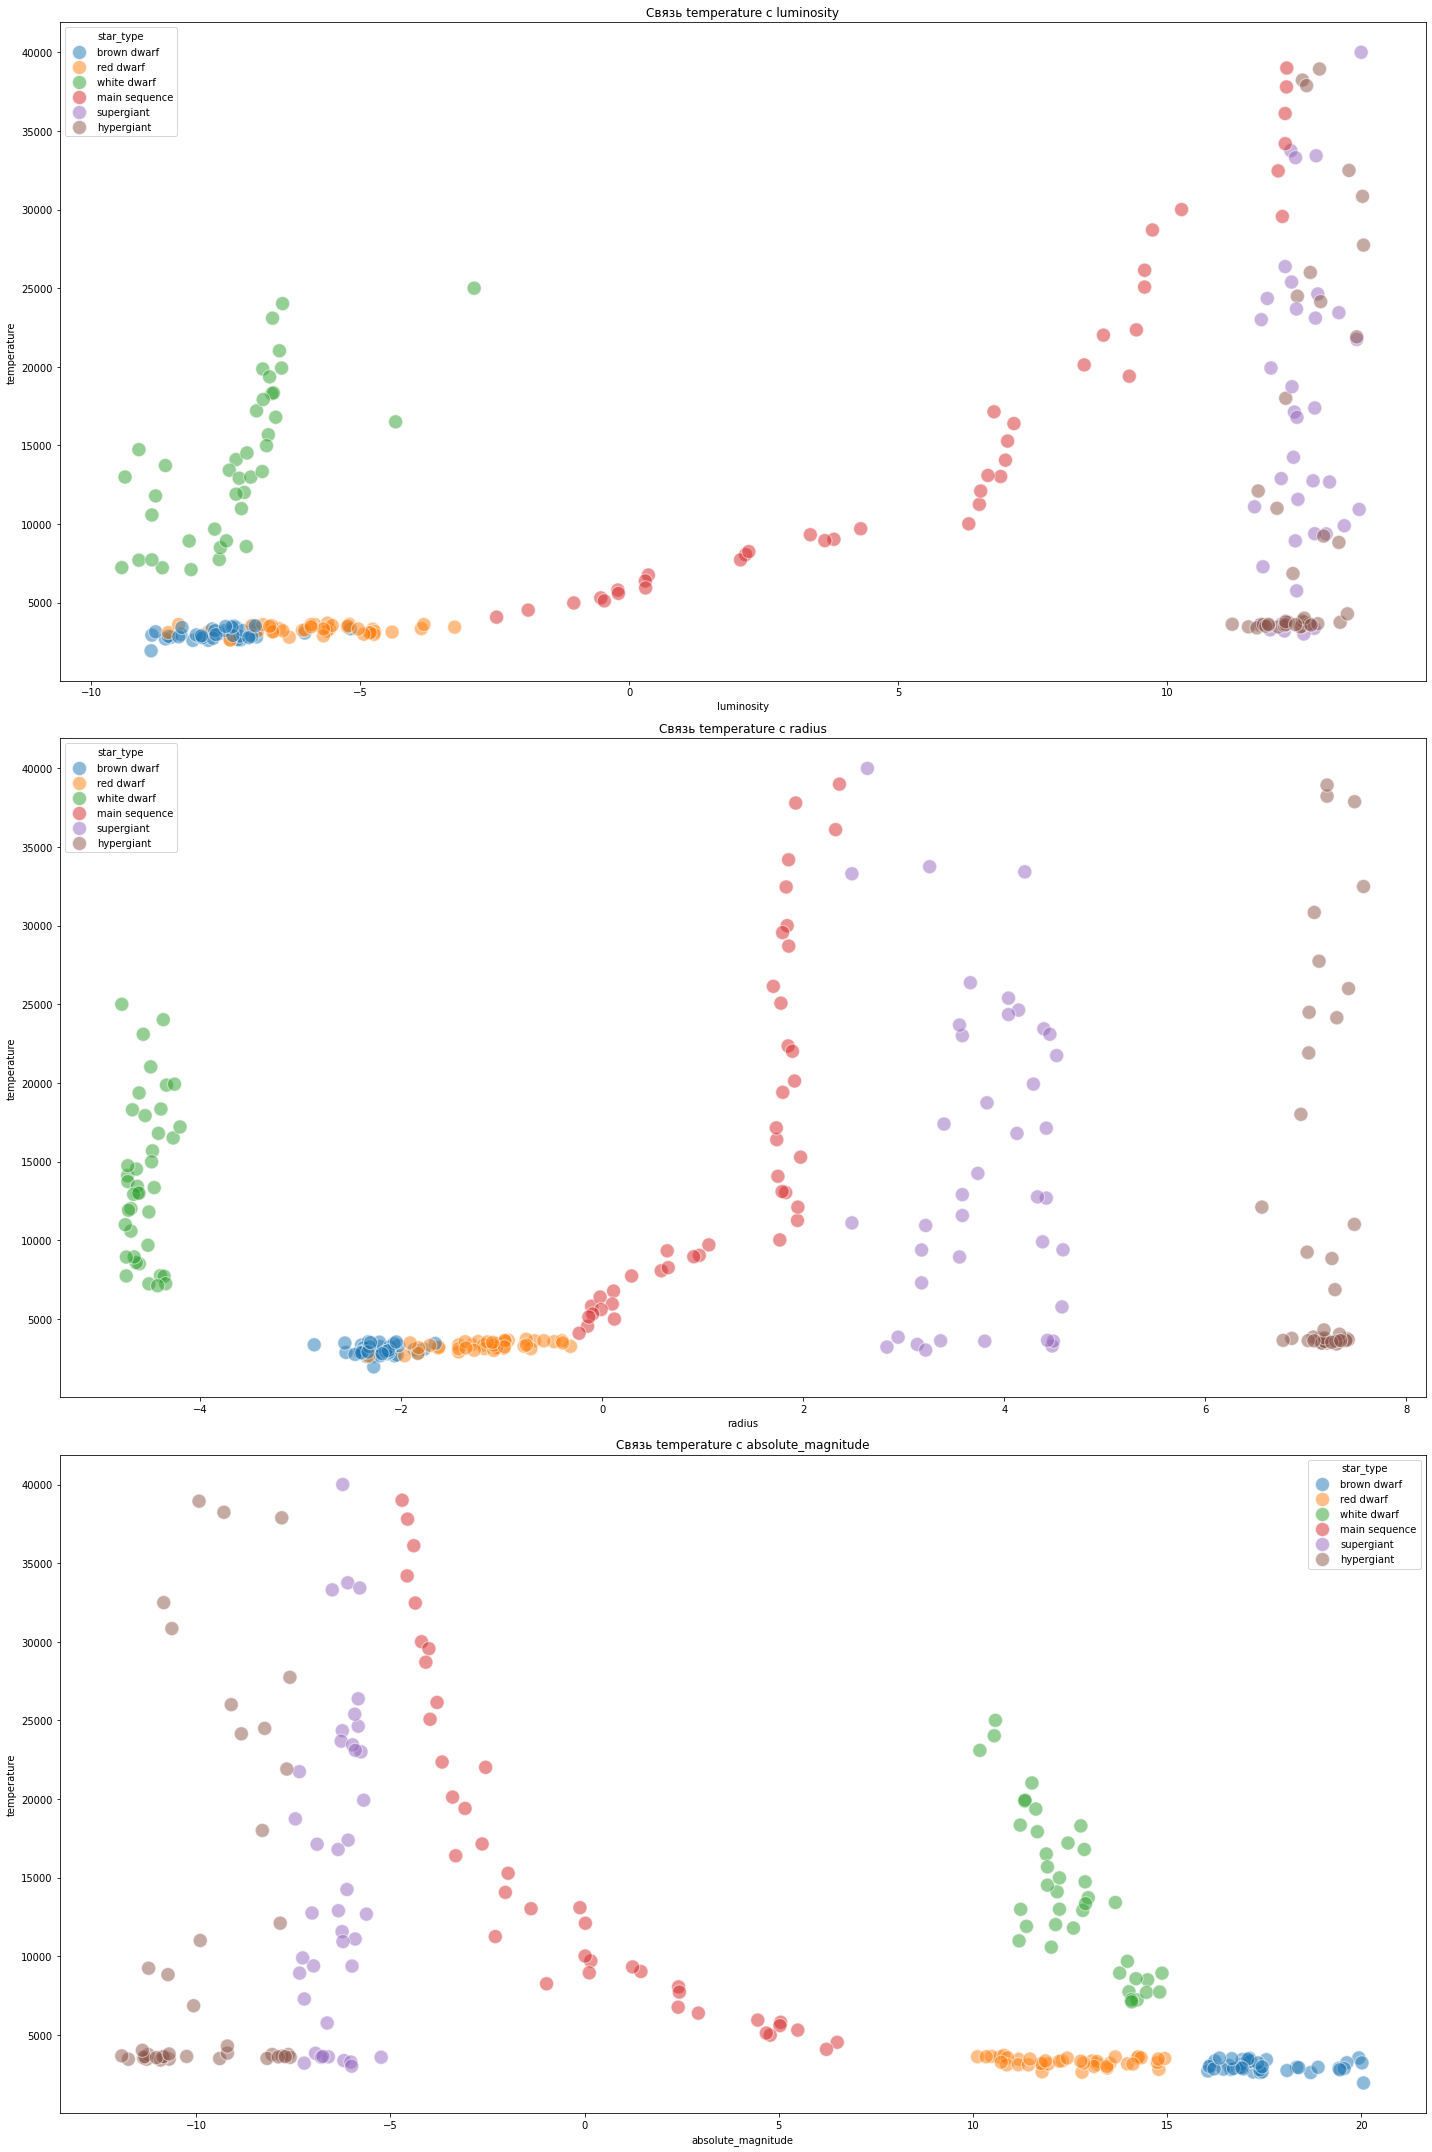

In [22]:
plot_scatter_plots(data, quantitative_scatter, hue='star_type')

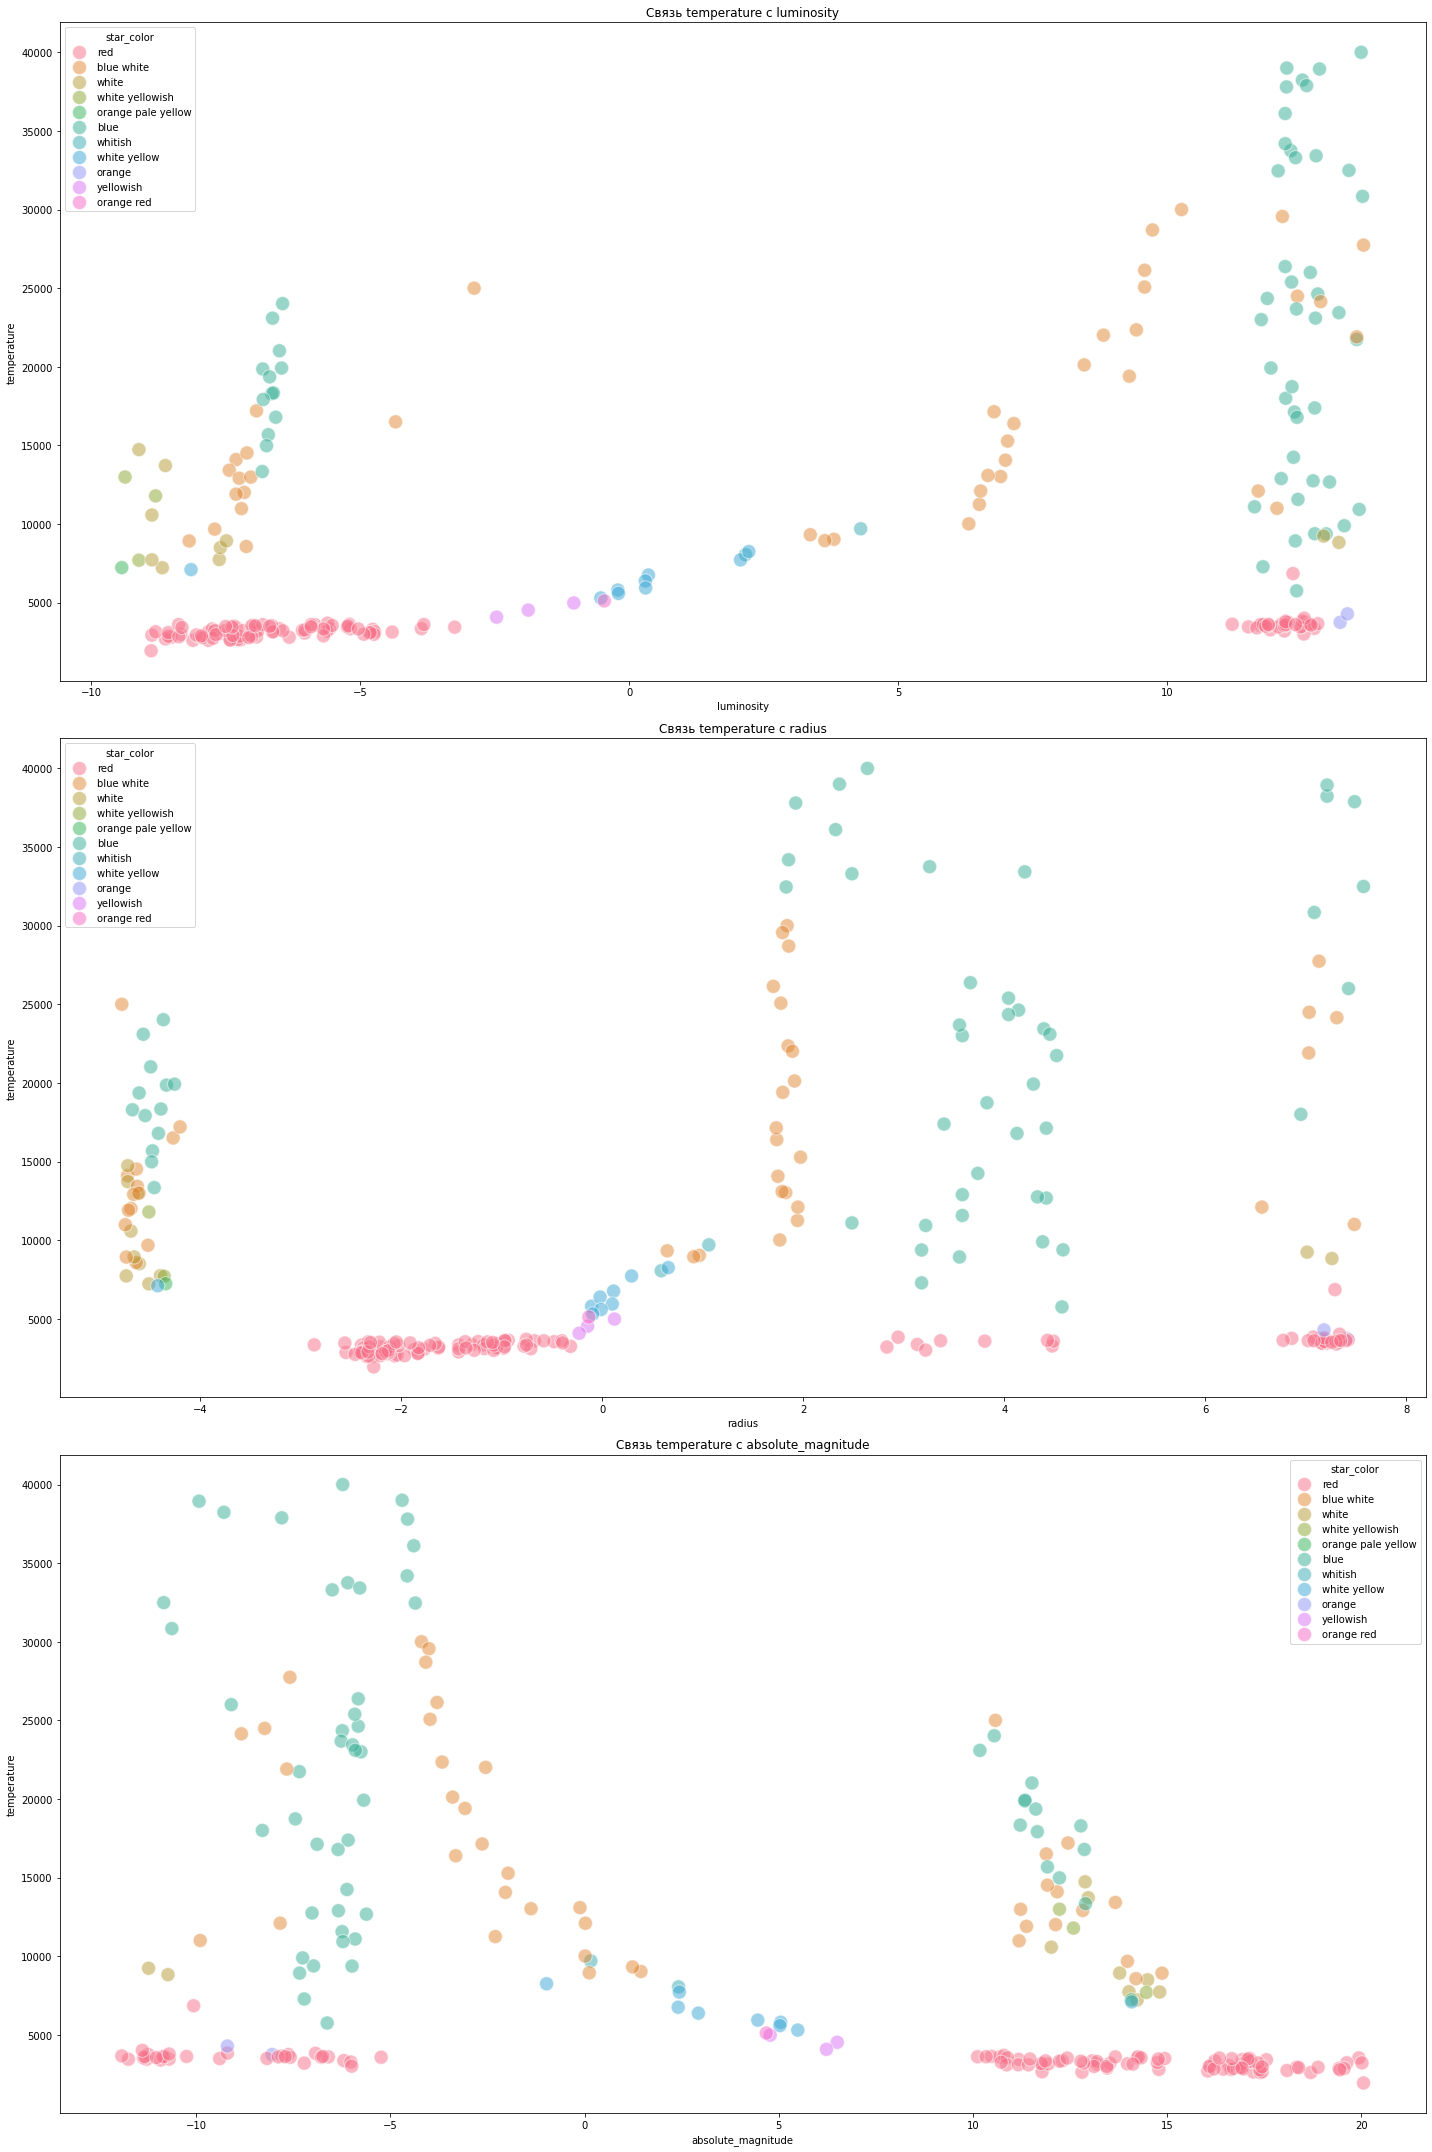

In [23]:
plot_scatter_plots(data, quantitative_scatter, hue='star_color')

In [24]:
data_color = data.query('star_color in ["white yellowish", "orange pale yellow", \
                        "white yellow", "orange", "yellowish", "orange red", "white", "whitish"]')

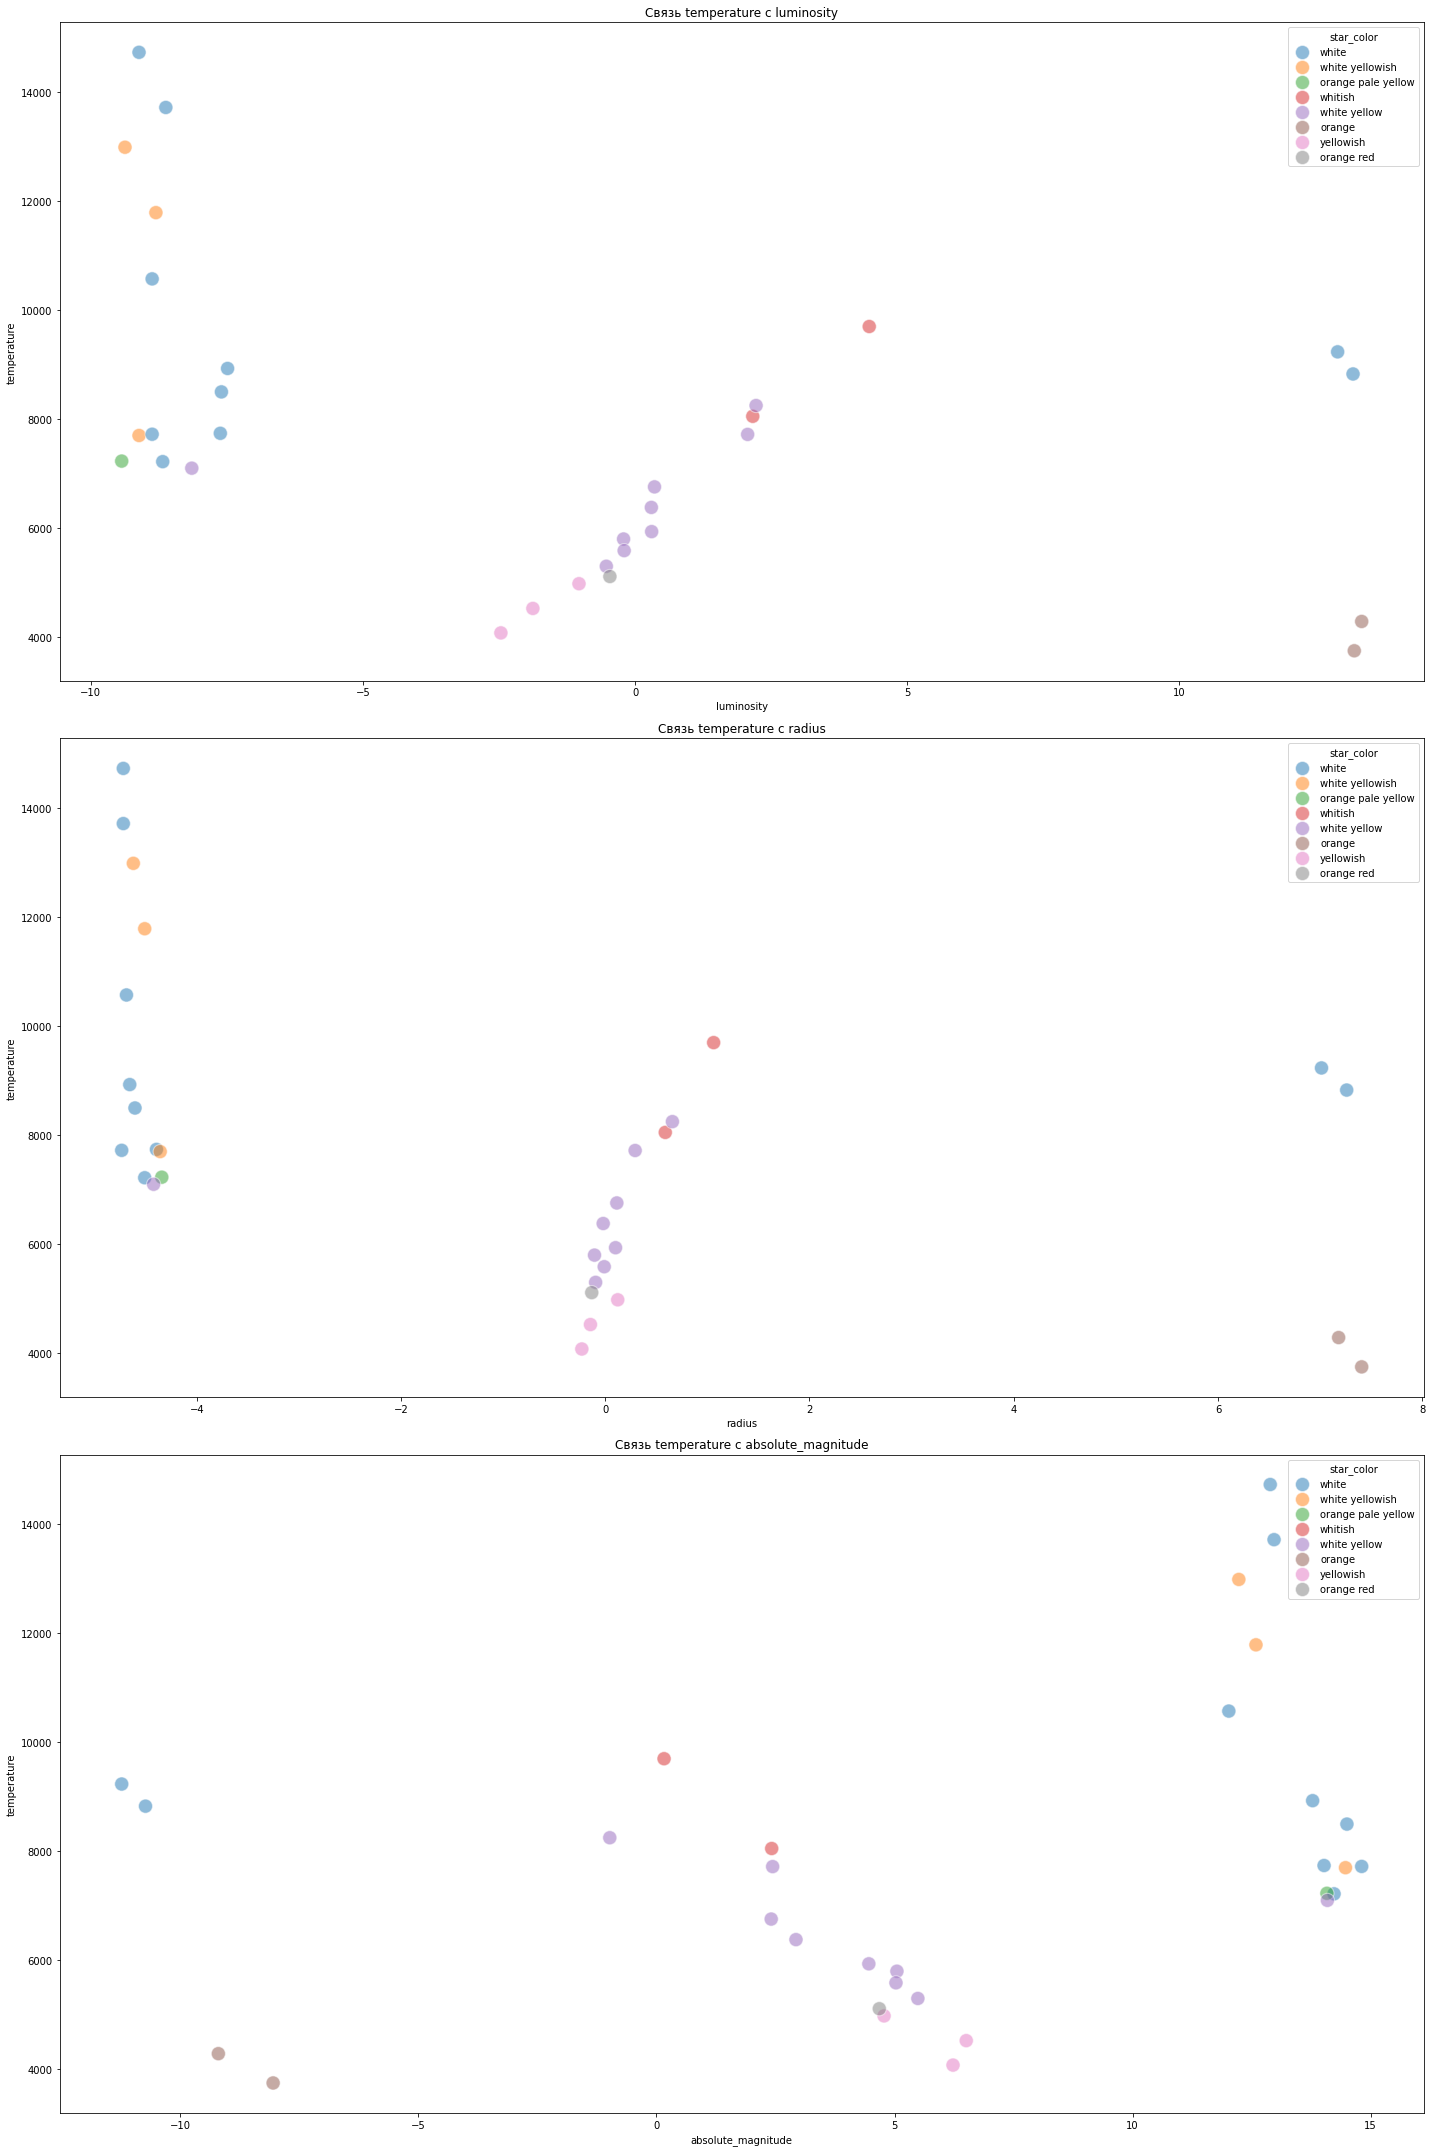

In [25]:
plot_scatter_plots(data_color, quantitative_scatter, hue='star_color')

Изучив распределение цветов по графикам, решили провести следующее объединение малочисленных цветов:

In [26]:
color_mapping_2 = {
    'orange red': 'orange',
    'orange pale yellow': 'yellow',
    'yellowish': 'orange',
    'white yellowish': 'white',
    'white yellow': 'yellow',
    'whitish': 'white',
}

data['star_color'] = data['star_color'].map(color_mapping_2).fillna(data['star_color'])

print(data['star_color'].value_counts())

star_color
red           112
blue           56
blue white     41
white          15
yellow         10
orange          6
Name: count, dtype: int64


Посмотрим корреляцию признаков.

In [27]:
interval = ['temperature', 'luminosity', 'radius', 'absolute_magnitude']

In [28]:
phik_target = data.phik_matrix(interval_cols=interval)

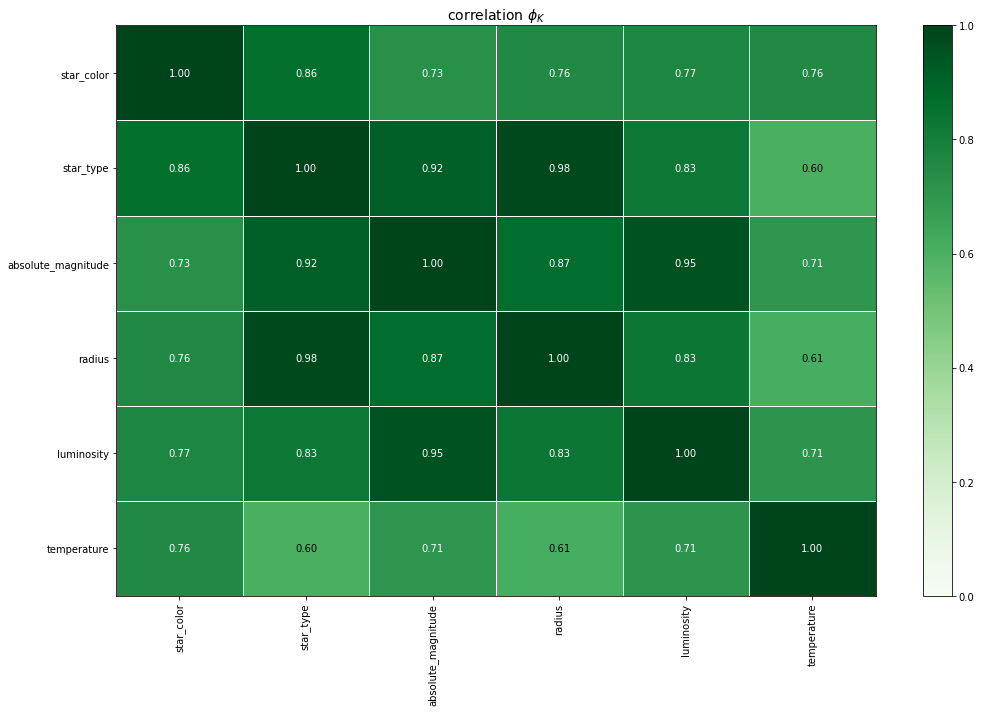

In [29]:
plot_correlation_matrix(phik_target.values, 
                        x_labels=phik_target.columns, 
                        y_labels=phik_target.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

**Наибольшая корреляция с температурой** наблюдается у:
   - `star_color` - 0.76
   - `absolute_magnitude` и `luminosity` - 0.71

**Средняя корреляция**:
   - `radius` и `star_type` - 0.61 и 0.6

In [30]:
data['star_type'] = data['star_type'].astype('category')
data['star_color'] = data['star_color'].astype('category')

### Вывод

- Удалили столбец `Unnamed: 0`
- Перевели названия столбцов в змеиный регистр
- Типы звезд переименовали в названия из описания к проекту.
- Укрупнили категории в параметре `star_color'
- Признаки `radius` и `luminosity` сильно скошены. Применили к ним логарифмирование для выравнивания.


**Температура**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.
  
**Относительная светимость**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.
  
**Относительный радиус**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.

**Абсолютная звёздная величина**
  - Признак без выбросов, имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика. Меньше всего значений в диапазоне 0-5.

**Категориальные признаки**
- Имеем равное распределение наблюдений по типам звезд - 40.
- В данных `star_color` преобладают звезды цветов `red`, `blue`, `blue white`.

**Наибольшая корреляция с температурой** наблюдается у:
   - `star_color` - 0.76
   - `absolute_magnitude` и `luminosity` - 0.71

**Средняя корреляция**:
   - `radius` и `star_type` - 0.61 и 0.6

## Построение базовой нейронной сети

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['temperature']),
    data.temperature,
    test_size=0.2,
    shuffle=True,
    random_state=45,
    #stratify=data['star_type']
)

# Выводим размеры выборок
print("Размер тренировочной выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер тренировочной выборки: (192, 5)
Размер тестовой выборки: (48, 5)


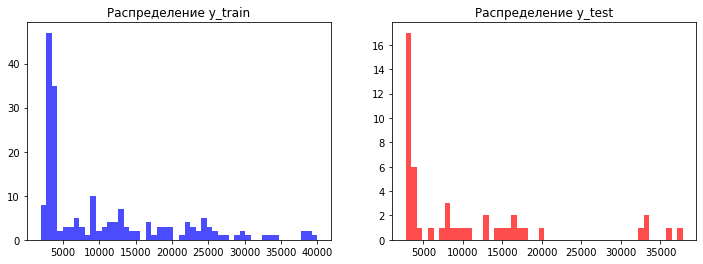

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50, color='blue', alpha=0.7, label='Train')
plt.title('Распределение y_train')
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=50, color='red', alpha=0.7, label='Test')
plt.title('Распределение y_test')
plt.show()

In [33]:
columns_numeric = ['luminosity', 'radius', 'absolute_magnitude']
columns_category = ['star_type', 'star_color']

In [34]:
preprocessor = ColumnTransformer(
            transformers=[
                ("numeric", StandardScaler(), columns_numeric),
                ("category", OneHotEncoder(handle_unknown='ignore', sparse_output=False), columns_category)
            ]
        )

In [35]:
preprocessor.fit(X_train)
features_train_p = preprocessor.transform(X_train)
features_test_p = preprocessor.transform(X_test)

In [36]:
X_train = torch.FloatTensor(features_train_p)
X_test = torch.FloatTensor(features_test_p)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [37]:
def train_base_model(X_train, y_train, X_test, y_test, 
                    hidden_neurons=[640, 320, 160],
                    learning_rate=1e-2,
                    num_epochs=5000,
                    patience=1,
                    min_delta=0.001,
                    seed=45):
    
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

    in_neurons = X_train.shape[1]
    hidden_neurons_1 = hidden_neurons[0]
    hidden_neurons_2 = hidden_neurons[1]
    hidden_neurons_3 = hidden_neurons[2]
    out_neurons = 1

    base_model = nn.Sequential(
        nn.Linear(in_neurons, hidden_neurons_1), 
        nn.ReLU(),
        nn.Linear(hidden_neurons_1, hidden_neurons_2), 
        nn.ReLU(),
        nn.Linear(hidden_neurons_2, hidden_neurons_3), 
        nn.ReLU(),
        nn.Linear(hidden_neurons_3, out_neurons), 
        nn.ReLU()
    )

    optimizer = torch.optim.Adam(base_model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()
    
    best_test_rmse_base = float('inf')
    counter = 0 

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = base_model.forward(X_train).flatten()
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            base_model.eval()
            train_preds = base_model.forward(X_train)
            train_rmse = root_mean_squared_error(y_train, train_preds.detach().numpy())
            
            test_preds = base_model.forward(X_test)
            test_rmse = root_mean_squared_error(y_test, test_preds.detach().numpy())
            
            print(f'Epoch {epoch} complete | Train RMSE: {train_rmse:.0f} | Test RMSE: {test_rmse:.0f}')
            base_model.train()
            
            if test_rmse + min_delta < best_test_rmse_base:
                best_test_rmse_base = test_rmse
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f'\nEarly stopping at epoch {epoch} - no improvement for {patience} epochs')
                    print(f'Best Test RMSE: {best_test_rmse_base:.0f}')
                    break
                    
    return base_model, best_test_rmse_base

In [38]:
base_model, best_rmse_base = train_base_model(X_train, y_train, X_test, y_test)

Epoch 0 complete | Train RMSE: 14201 | Test RMSE: 14085
Epoch 10 complete | Train RMSE: 12423 | Test RMSE: 12410
Epoch 20 complete | Train RMSE: 8244 | Test RMSE: 8685
Epoch 30 complete | Train RMSE: 6187 | Test RMSE: 6562
Epoch 40 complete | Train RMSE: 5415 | Test RMSE: 5627
Epoch 50 complete | Train RMSE: 5035 | Test RMSE: 5030
Epoch 60 complete | Train RMSE: 4637 | Test RMSE: 4713
Epoch 70 complete | Train RMSE: 4384 | Test RMSE: 4485
Epoch 80 complete | Train RMSE: 4215 | Test RMSE: 4346
Epoch 90 complete | Train RMSE: 4109 | Test RMSE: 4267
Epoch 100 complete | Train RMSE: 4039 | Test RMSE: 4236
Epoch 110 complete | Train RMSE: 3981 | Test RMSE: 4206
Epoch 120 complete | Train RMSE: 3926 | Test RMSE: 4150
Epoch 130 complete | Train RMSE: 3870 | Test RMSE: 4097
Epoch 140 complete | Train RMSE: 3813 | Test RMSE: 4054
Epoch 150 complete | Train RMSE: 3756 | Test RMSE: 4015
Epoch 160 complete | Train RMSE: 3700 | Test RMSE: 3986
Epoch 170 complete | Train RMSE: 3647 | Test RMSE: 3962

In [39]:
def final_bar(predict, num_bar=30):
    x = np.arange(num_bar)
    plt.figure(figsize = (20,8))
    plt.bar(x, predict[:num_bar], width = 0.6, color = 'blue', edgecolor = 'black', label='Предсказание', alpha=0.5)
    plt.bar(x, y_test[:num_bar], width = 0.3, color = 'yellow', edgecolor = 'black', label='Действительное значение')
    plt.title('Сравнение предсказания и действительных температур')
    plt.ylabel('Температура звезды')
    plt.xlabel('Номер звезды')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

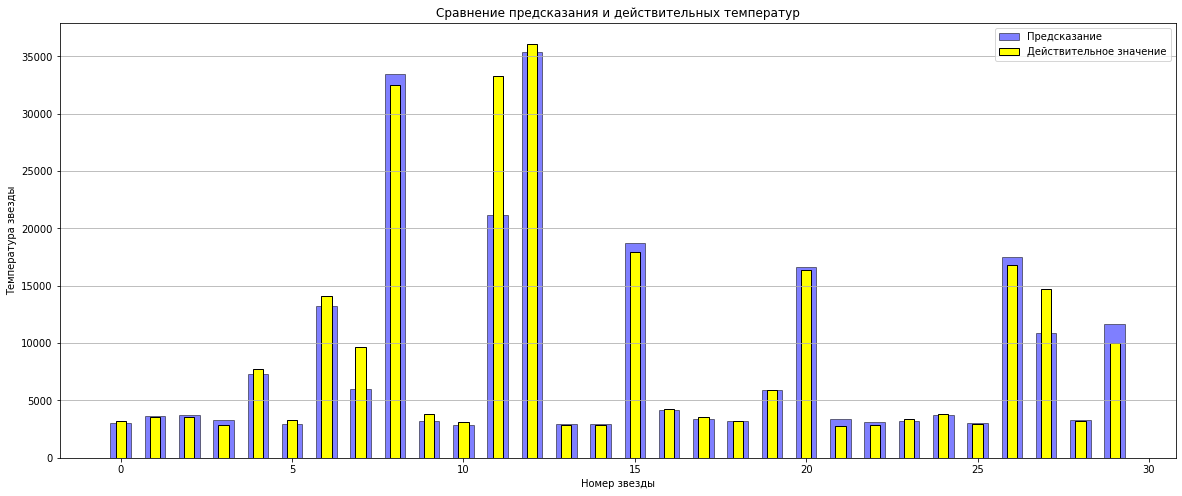

In [40]:
base_model.eval()
test_preds_base = base_model(X_test).detach().numpy().flatten()

# Строим график
final_bar(test_preds_base)

### Вывод

**Описание нейронной сети `base_model`**

1. Архитектура модели
Модель представляет собой нейронную сеть с следующими характеристиками:
- **Входной слой**: размерность соответствует количеству признаков в данных.
- **Скрытые слои**:
  - Первый скрытый слой: 640 нейронов с функцией активации ReLU
  - Второй скрытый слой: 320 нейронов с функцией активации ReLU
  - Третий скрытый слой: 160 нейрона с функцией активации ReLU
- **Выходной слой**: 1 нейрон с функцией активации ReLU.

2. Обучение модели
- **Оптимизатор**: Adam с learning rate = 0.01
- **Функция потерь**: MSE (Mean Squared Error)
- **Эпохи**: максимум 5000, но с ранней остановкой
- **Ранняя остановка**: срабатывает, если улучшение RMSE на тестовой выборке меньше 0.001 в течение 1 эпохи

**Результаты**
- `Train RMSE` - 3227
- `Test RMSE` - 3367

**Сравнение предсказания и действительных температур**

График сопоставления предсказанных и фактических значений температур звёзд показывает, что нейронная сеть успешно предсказывает температуру с высокой точностью для звёзд с температурой не выше 5000 К. Для звезд температурой более 10000 К `base_model` допускает значительную ошибку в 5000 - 10000 К.

## Улучшение нейронной сети

In [43]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test, 
                            dropout_rates=[0.1, 0.3, 0.6], 
                            batch_sizes=[32, 64, 128],
                            hidden_neurons=[640, 320, 160],
                            num_epochs=5000,
                            patience=1,
                            min_delta=0.001,
                            lr=1e-2):
    
    # Создаем базовую модель
    in_neurons = X_train.shape[1]
    hidden_neurons_1, hidden_neurons_2, hidden_neurons_3 = hidden_neurons
    out_neurons = 1

    def create_model(dropout_rate):
        return nn.Sequential(
            nn.Linear(in_neurons, hidden_neurons_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_neurons_1, hidden_neurons_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_neurons_2, hidden_neurons_3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_neurons_3, out_neurons),
            nn.ReLU()
        )

    results = []

    for dropout_rate, batch_size in product(dropout_rates, batch_sizes):
        print(f"\nTraining model with dropout_rate={dropout_rate}, batch_size={batch_size}")
        
        net = create_model(dropout_rate)
        
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        
        best_test_rmse_cre = float('inf')
        counter = 0
        
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(num_epochs):
            net.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                preds = net(batch_X).flatten()
                loss_value = loss_fn(preds, batch_y)
                loss_value.backward()
                optimizer.step()
            
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                net.eval()
                # Вычисляем RMSE для обучающей выборки
                with torch.no_grad():
                    train_preds = net(X_train)
                    train_rmse = root_mean_squared_error(y_train, train_preds.numpy())
                    
                    # Вычисляем RMSE для тестовой выборки
                    test_preds_cre = net(X_test)
                    test_rmse = root_mean_squared_error(y_test, test_preds_cre.numpy())
                
                print(f'Epoch {epoch} | Train RMSE: {train_rmse:.0f} | Test RMSE: {test_rmse:.0f}')
                
                # Проверяем условие ранней остановки
                if test_rmse + min_delta < best_test_rmse_cre:
                    best_test_rmse_cre = test_rmse
                    counter = 0
                    # Сохраняем лучшие веса для этой комбинации параметров
                    best_weights = net.state_dict().copy()
                else:
                    counter += 1
                    if counter >= patience:
                        print(f'Early stopping at epoch {epoch}')
                        print(f'Best Test RMSE: {best_test_rmse_cre:.0f}')
                        break
        
        # Сохраняем результаты этой комбинации
        results.append({
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'best_test_rmse_cre': best_test_rmse_cre,
            'model_weights': best_weights
        })

    # Находим лучшую комбинацию параметров
    best_result = min(results, key=lambda x: x['best_test_rmse_cre'])

    print("\nBest model parameters:")
    print(f"Dropout rate: {best_result['dropout_rate']}")
    print(f"Batch size: {best_result['batch_size']}")
    print(f"Test RMSE: {best_result['best_test_rmse_cre']:.0f}")

    # Создаем и загружаем веса лучшей модели
    create_model = create_model(best_result['dropout_rate'])
    create_model.load_state_dict(best_result['model_weights'])
    
    return create_model, best_result

In [45]:
# Обучаем модели
create_model, best_result = train_and_evaluate_models(
    X_train, y_train, 
    X_test, y_test,
    dropout_rates=[0.1, 0.3, 0.6],
    batch_sizes=[32, 64, 128],
    hidden_neurons=[640, 320, 160]
)


Training model with dropout_rate=0.1, batch_size=32
Epoch 0 | Train RMSE: 13907 | Test RMSE: 13805
Epoch 10 | Train RMSE: 4889 | Test RMSE: 4835
Epoch 20 | Train RMSE: 4023 | Test RMSE: 4216
Epoch 30 | Train RMSE: 3957 | Test RMSE: 4208
Epoch 40 | Train RMSE: 3850 | Test RMSE: 4152
Epoch 50 | Train RMSE: 3881 | Test RMSE: 4163
Early stopping at epoch 50
Best Test RMSE: 4152

Training model with dropout_rate=0.1, batch_size=64
Epoch 0 | Train RMSE: 14152 | Test RMSE: 14038
Epoch 10 | Train RMSE: 6002 | Test RMSE: 6279
Epoch 20 | Train RMSE: 4495 | Test RMSE: 4575
Epoch 30 | Train RMSE: 4107 | Test RMSE: 4340
Epoch 40 | Train RMSE: 3961 | Test RMSE: 4185
Epoch 50 | Train RMSE: 3866 | Test RMSE: 4131
Epoch 60 | Train RMSE: 3782 | Test RMSE: 4037
Epoch 70 | Train RMSE: 3714 | Test RMSE: 3993
Epoch 80 | Train RMSE: 3659 | Test RMSE: 3980
Epoch 90 | Train RMSE: 3678 | Test RMSE: 4035
Early stopping at epoch 90
Best Test RMSE: 3980

Training model with dropout_rate=0.1, batch_size=128
Epoch 

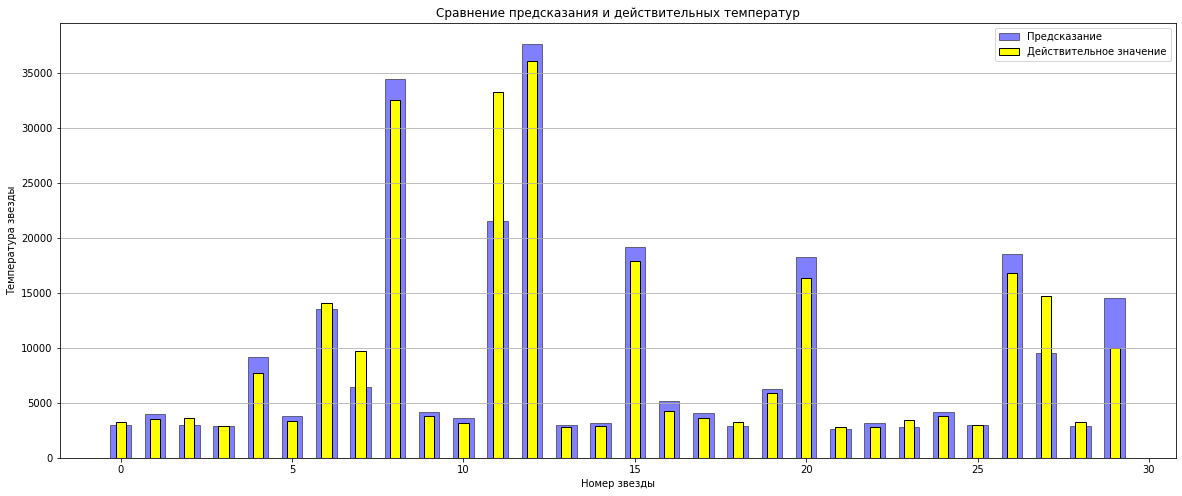

In [46]:
create_model.eval()
test_preds_cre = create_model(X_test).detach().numpy().flatten()

# Строим график
final_bar(test_preds_cre)

### Вывод

**Описание нейронной сети `create_model`**

**Архитектура**
1. **Входной слой**: 
   - Размерность определяется количеством признаков

2. **Скрытые слои**:
   - Первый скрытый слой: 640 нейронов + ReLU активация + `Dropout`
   - Второй скрытый слой: 320 нейронов + ReLU активация + `Dropout`
   - Третий скрытый слой: 160 нейрона + ReLU активация + `Dropout`

3. **Выходной слой**: 
   - 1 нейрон  с ReLU активацией

**Регуляризация**
- **`Dropout`**: применяется после каждого скрытого слоя с одинаковым коэффициентом `dropout_rate` (перебираются значения `[0.1, 0.3, 0.6]`)

**Обучение**
- **Оптимизатор**: `Adam с learning rate 0.01`
- **Функция потерь**: `MSE`
- **Размер батча**: перебираются значения `[32, 64, 128]`
- **Количество эпох**: до 5000 с ранней остановкой

**Результаты**
- `Train RMSE` - 3659
- `Test RMSE` - 3980
- Best model parameters:
    - Dropout rate: 0.1
    - Batch size: 64

**Сравнение предсказания и действительных температур**
График сопоставления предсказанных и фактических значений температур звёзд показывает, что нейронная сеть успешно предсказывает температуру с высокой точностью для звёзд с температурой не выше 5000 К. Для звезд температурой более 10000 К `create_model` допускает значительную ошибку в 5000 - 10000 К.

## Сравнение моделей

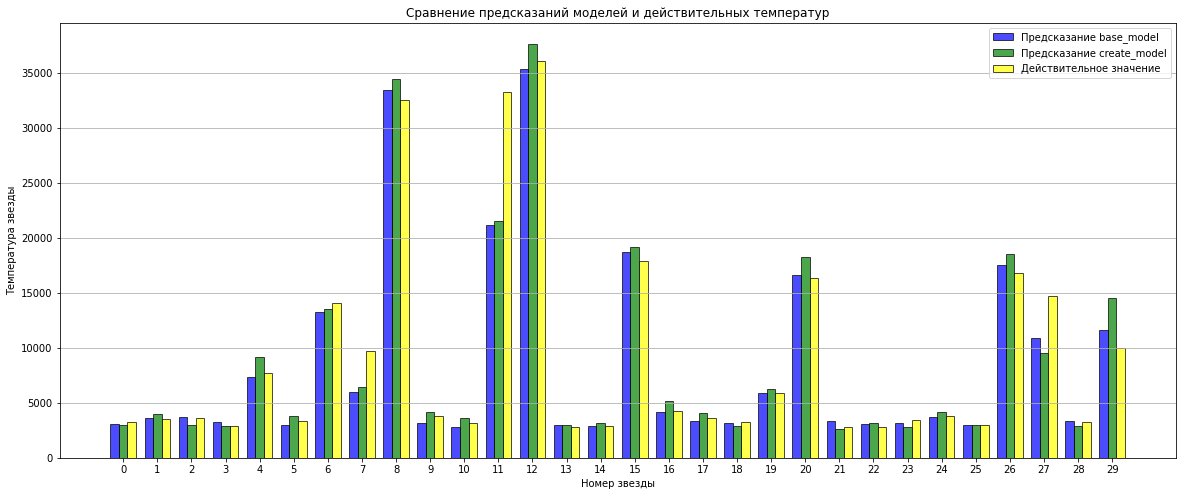

In [47]:
def compare_models_bar(predict1, predict2, true_values, num_bar=30):
    x = np.arange(num_bar)
    width = 0.25  # Ширина столбцов
    
    plt.figure(figsize=(20, 8))
    
    # Столбцы для первого предсказания (base_model)
    plt.bar(x - width, predict1[:num_bar], width=width, 
            color='blue', edgecolor='black', 
            label='Предсказание base_model', alpha=0.7)
    
    # Столбцы для второго предсказания (create_model)
    plt.bar(x, predict2[:num_bar], width=width, 
            color='green', edgecolor='black', 
            label='Предсказание create_model', alpha=0.7)
    
    # Столбцы для реальных значений
    plt.bar(x + width, true_values[:num_bar], width=width, 
            color='yellow', edgecolor='black', 
            label='Действительное значение', alpha=0.7)
    
    plt.title('Сравнение предсказаний моделей и действительных температур')
    plt.ylabel('Температура звезды')
    plt.xlabel('Номер звезды')
    plt.legend()
    plt.grid(axis='y')
    plt.xticks(x)  # Чтобы метки по оси x были целыми числами
    plt.show()

# Вызов функции с вашими данными
compare_models_bar(test_preds_base, test_preds_cre, y_test)

In [48]:
def get_layers_info(model):
    """Извлекает информацию о слоях модели"""
    layers_info = []
    for layer in model:
        if isinstance(layer, torch.nn.Linear):
            layers_info.append(f"Linear(in_features={layer.in_features}, out_features={layer.out_features}, bias={layer.bias is not None})")
        elif isinstance(layer, torch.nn.ReLU):
            layers_info.append("ReLU()")
        elif isinstance(layer, torch.nn.Dropout):
            layers_info.append(f"Dropout(p={layer.p}, inplace={layer.inplace})")
        else:
            layers_info.append(str(layer))  
    return layers_info

base_layers = get_layers_info(base_model)
best_layers = get_layers_info(create_model)

best_batch_size = best_result['batch_size']
best_test_rmse_cre = best_result['best_test_rmse_cre']

# Создаем таблицу
styled_table = []

for i in range(max(len(base_layers), len(best_layers))):
    base = base_layers[i] if i < len(base_layers) else " "
    best = best_layers[i] if i < len(best_layers) else " "
    
    base_fmt = base.replace("in_features=", "").replace("out_features=", "").replace("bias=", "")
    best_fmt = best.replace("in_features=", "").replace("out_features=", "").replace("bias=", "")
    
    styled_table.append([
        f" {i}",
        base_fmt,
        f" {best_fmt}" if best != " " else " "
    ])

# Добавляем batch size
styled_table.append(["Batch", "-", f" {best_batch_size}"])

# Добавляем метрики RMSE
styled_table.append(["Test RMSE", f" {best_rmse_base:.0f}", f" {best_test_rmse_cre:.0f}"])

headers = ["#", "Base Model", "Create Model"]
print(tabulate(styled_table, headers, tablefmt="simple_grid", stralign="left"))

┌───────────┬────────────────────────┬───────────────────────────────┐
│ #         │ Base Model             │ Create Model                  │
├───────────┼────────────────────────┼───────────────────────────────┤
│ 0         │ Linear(15, 640, True)  │ Linear(15, 640, True)         │
├───────────┼────────────────────────┼───────────────────────────────┤
│ 1         │ ReLU()                 │ ReLU()                        │
├───────────┼────────────────────────┼───────────────────────────────┤
│ 2         │ Linear(640, 320, True) │ Dropout(p=0.1, inplace=False) │
├───────────┼────────────────────────┼───────────────────────────────┤
│ 3         │ ReLU()                 │ Linear(640, 320, True)        │
├───────────┼────────────────────────┼───────────────────────────────┤
│ 4         │ Linear(320, 160, True) │ ReLU()                        │
├───────────┼────────────────────────┼───────────────────────────────┤
│ 5         │ ReLU()                 │ Dropout(p=0.1, inplace=False) │
├─────

### Вывод

Базовая нейронная сеть проявила себя лучше, `Test RMSE` = 3367.

## Общий вывод

1. **Объем данных**  
   В датасете содержится 240 наблюдений (строк). Каждая строка соответствует одной звезде.

2. **Температура (K)**  
   - Средняя температура звезд составляет около **10 497 K**, но разброс значений очень велик (стандартное отклонение — **9 552 K**).  
   - Минимальная температура: **1 939 K**, максимальная — **40 000 K**.  
   - Медиана (**5 776 K**) значительно ниже среднего, что указывает на правостороннюю асимметрию (большое количество относительно холодных звезд и несколько экстремально горячих).

3. **Светимость (L/Lo)**  
   - Средняя светимость (**107 188 L/Lo**) сильно завышена из-за выбросов (стандартное отклонение — **179 432**).  
   - Медиана (**0.0705 L/Lo**) близка к нулю, что говорит о преобладании звезд с низкой светимостью .  
   - Максимальная светимость (**849 420 L/Lo**) соответствует сверхгигантам.  

4. **Радиус (R/Ro)**  
   - Средний радиус (**237 R/Ro**) также искажен выбросами (стандартное отклонение — **517**).  
   - Медиана (**0.7625 R/Ro**) близка к солнечному радиусу, но есть звезды с радиусом до **1 948.5 R/Ro** (гипергиганты).  
   - Минимальный радиус (**0.0084 R/Ro**) может соответствовать белым карликам или нейтронным звездам.  

5. **Абсолютная звездная величина (Mv)**  
   - Среднее значение (**4.38**) малопоказательно из-за большого разброса (**σ = 10.53**).  
   - Медиана (**8.31**) указывает на преобладание тусклых звезд.  
   - Минимальное значение (**-11.92**) характерно для очень ярких звезд (например, сверхновых).  

- Удалили столбец `Unnamed: 0`
- Перевели названия столбцов в змеиный регистр
- Типы звезд переименовали в названия из описания к проекту.
- Укрупнили категории в параметре `star_color'
- Признаки `radius` и `luminosity` сильно скошены. Применили к ним логарифмирование для выравнивания.


**Температура**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.
  
**Относительная светимость**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.
  
**Относительный радиус**
  - Гистограмма показывает, что данные являются асимметричными, с выраженной положительной асимметрией.
  - Большинство наблюдений сосредоточены в диапазоне около 5000, с уменьшением количества значений при увеличении температуры.
  - На диаграмме размаха видны выбросы от значений, выше 34000 К.

**Абсолютная звёздная величина**
  - Признак без выбросов, имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика. Меньше всего значений в диапазоне 0-5.

**Категориальные признаки**
- Имеем равное распределение наблюдений по типам звезд - 40.
- В данных `star_color` преобладают звезды цветов `red`, `blue`, `blue white`.

**Наибольшая корреляция с температурой** наблюдается у:
   - `star_color` - 0.76
   - `absolute_magnitude` и `luminosity` - 0.71

**Средняя корреляция**:
   - `radius` и `star_type` - 0.61 и 0.6

**Описание нейронной сети `base_model`**

1. Архитектура модели
Модель представляет собой нейронную сеть с следующими характеристиками:
- **Входной слой**: размерность соответствует количеству признаков в данных.
- **Скрытые слои**:
  - Первый скрытый слой: 640 нейронов с функцией активации ReLU
  - Второй скрытый слой: 320 нейронов с функцией активации ReLU
  - Третий скрытый слой: 160 нейрона с функцией активации ReLU
- **Выходной слой**: 1 нейрон с функцией активации ReLU.

2. Обучение модели
- **Оптимизатор**: Adam с learning rate = 0.01
- **Функция потерь**: MSE (Mean Squared Error)
- **Эпохи**: максимум 5000, но с ранней остановкой
- **Ранняя остановка**: срабатывает, если улучшение RMSE на тестовой выборке меньше 0.001 в течение 1 эпохи

**Результаты**
- `Train RMSE` - 3227
- `Test RMSE` - 3367

**Сравнение предсказания и действительных температур**

График сопоставления предсказанных и фактических значений температур звёзд показывает, что нейронная сеть успешно предсказывает температуру с высокой точностью для звёзд с температурой не выше 5000 К. Для звезд температурой более 10000 К `base_model` допускает значительную ошибку в 5000 - 10000 К.

**Описание нейронной сети `create_model`**

**Архитектура**
1. **Входной слой**: 
   - Размерность определяется количеством признаков

2. **Скрытые слои**:
   - Первый скрытый слой: 640 нейронов + ReLU активация + `Dropout`
   - Второй скрытый слой: 320 нейронов + ReLU активация + `Dropout`
   - Третий скрытый слой: 160 нейрона + ReLU активация + `Dropout`

3. **Выходной слой**: 
   - 1 нейрон  с ReLU активацией

**Регуляризация**
- **`Dropout`**: применяется после каждого скрытого слоя с одинаковым коэффициентом `dropout_rate` (перебираются значения `[0.1, 0.3, 0.6]`)

**Обучение**
- **Оптимизатор**: `Adam с learning rate 0.01`
- **Функция потерь**: `MSE`
- **Размер батча**: перебираются значения `[32, 64, 128]`
- **Количество эпох**: до 5000 с ранней остановкой

**Результаты**
- `Train RMSE` - 3659
- `Test RMSE` - 3980
- Best model parameters:
    - Dropout rate: 0.1
    - Batch size: 64

**Сравнение предсказания и действительных температур**
График сопоставления предсказанных и фактических значений температур звёзд показывает, что нейронная сеть успешно предсказывает температуру с высокой точностью для звёзд с температурой не выше 5000 К. Для звезд температурой более 10000 К `create_model` допускает значительную ошибку в 5000 - 10000 К.

Базовая нейронная сеть проявила себя лучше, `Test RMSE` = 3367.